In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
import os
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
transform_totensor = transforms.Compose([
    transforms.ToTensor(),
])

transform_toimage = transforms.ToPILImage()

In [27]:
class AnimalFaces_Dataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = os.listdir(folder_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        img=transform_totensor(Image.open(file_path))
        return img.view(-1)

In [3]:
class AnimalFaces_Dataset_InMemory(Dataset):
    def __init__(self, folder_path):
        file_list = os.listdir(folder_path)
        self.data={}
        count=0
        for file_name in file_list:
            count+=1
            file_path = os.path.join(folder_path, file_name)
            img=transform_totensor(Image.open(file_path))
            self.data[count]=img.view(-1).tolist()
        self.data=torch.tensor(list(self.data.values()))

    def to(this,device):
        this.data=this.data.to(device)
        return this
        
    def __len__(self):
        return self.data.shape[0]
    
    def shape(this):
        return this.data.shape

    def __getitem__(self, index):
        return self.data[index]

In [4]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
total_dataset_path="./data/processed/total"
train_dataset_path="./data/processed/train"
val_dataset_path="./data/processed/val"

In [31]:
train_dataset=AnimalFaces_Dataset(train_dataset_path)
val_dataset=AnimalFaces_Dataset(val_dataset_path)

In [6]:
train_dataset_inmemory=AnimalFaces_Dataset_InMemory(train_dataset_path).to(device)
val_dataset_inmemory=AnimalFaces_Dataset_InMemory(val_dataset_path).to(device)

In [13]:
print(len(train_dataset_inmemory))
len(val_dataset_inmemory)

14630


1500

In [7]:
train_dataloader_vae = DataLoader(train_dataset,batch_size=256, shuffle=True, pin_memory=True)
val_dataloader_vae = DataLoader(val_dataset,batch_size=256, shuffle=True, pin_memory=True)

In [7]:
train_dataloader_vae_inmemory = DataLoader(train_dataset_inmemory,batch_size=512, shuffle=True)
val_dataloader_vae_inmemory = DataLoader(val_dataset_inmemory,batch_size=512, shuffle=True)

* Encoder and Decoder MLP

In [8]:
class MLP(nn.Module):
    def __init__(this,layers_lst):
        super().__init__()
        this.layers=nn.ModuleList()
        for in_dim, out_dim in layers_lst:
            this.layers.append(nn.Linear(in_dim,out_dim))
        this.activation=nn.Sigmoid()
    
    def forward(this,x):
        x=x
        for lyr in this.layers[:-1]:
            x=lyr(x)
            x=this.activation(x)
        return this.layers[-1](x)

* VAE Model

In [9]:
class VAE(nn.Module):
    def __init__(this,enc_layers,dec_layers):
        if(enc_layers[-1][1] != 2*dec_layers[0][0]):
            print("ERROR:Latent variable dimension missmatch with encoder output dimension")
            return
        super().__init__()
        this.ENC=MLP(enc_layers)
        this.DEC=MLP(dec_layers)
        this.z_dim=dec_layers[0][0]
        this.x_dim=dec_layers[-1][1]
        this.MVG=None
    
    def forward(this,x,L=1):
        device=next(this.parameters()).device
        if(this.MVG==None):
            mean=torch.zeros(this.z_dim).to(device)
            var=torch.eye(this.z_dim).to(device)
            this.MVG=torch.distributions.MultivariateNormal(mean, var)

        #Encoder
        x=this.ENC(x)

        #sampling
        mean_batch=x[:,:this.z_dim]
        sd_batch=x[:,this.z_dim:]

        z=torch.empty(0,this.z_dim,device=device)
        for _ in range(L):
            z=torch.cat((z,this.MVG.sample().unsqueeze(dim=0)),dim=0)
        
        #z=torch.matmul(z,var_clk_batch.view(var_clk_batch.shape[0],this.z_dim,this.z_dim))
        temp_z=torch.empty(0,this.z_dim,device=device)

        for mean_idx in range(mean_batch.shape[0]):
            temp_z=torch.cat((temp_z,(z*sd_batch[mean_idx])+mean_batch[mean_idx]),dim=0)

        #Decoder
        x=this.DEC(temp_z)

        return x , mean_batch, sd_batch
    
    def generate(this,x=None,num_samples=1):
        device=next(this.parameters()).device
        if(x!=None):
            x_mean, z_mean_batch, z_sd_batch = this.forward(x)
            return torch.randn(x_mean.shape,device=device)+x_mean
        
        else:
            if(this.MVG==None):
                mean=torch.zeros(this.z_dim).to(device)
                var=torch.eye(this.z_dim).to(device)
                this.MVG=torch.distributions.MultivariateNormal(mean, var)
            
            z=torch.empty(0,this.z_dim,device=device)
            for _ in range(num_samples):
                z=torch.cat((z,this.MVG.sample().unsqueeze(dim=0)),dim=0)
            
            x_mean=this.DEC(z)

            return torch.randn(x_mean.shape,device=device)+x_mean
    
    def postirior_infer(this,x,L=1):
        device=next(this.parameters()).device
        if(this.MVG==None):
            mean=torch.zeros(this.z_dim).to(device)
            var=torch.eye(this.z_dim).to(device)
            this.MVG=torch.distributions.MultivariateNormal(mean, var)

        #Encoder
        x=this.ENC(x)

        #sampling
        mean_batch=x[:,:this.z_dim]
        sd_batch=x[:,this.z_dim:]

        z=torch.empty(0,this.z_dim,device=device)
        for _ in range(L):
            z=torch.cat((z,this.MVG.sample().unsqueeze(dim=0)),dim=0)
        
        #z=torch.matmul(z,var_clk_batch.view(var_clk_batch.shape[0],this.z_dim,this.z_dim))
        temp_z=torch.empty(0,this.z_dim,device=device)

        for mean_idx in range(mean_batch.shape[0]):
            temp_z=torch.cat((temp_z,(z*sd_batch[mean_idx])+mean_batch[mean_idx]),dim=0)

        return mean_batch, sd_batch, temp_z



In [10]:
class VAE_m2(nn.Module):
    def __init__(this,enc_layers,dec_layers):
        if(enc_layers[-1][1] != 2*dec_layers[0][0]):
            print("ERROR:Latent variable dimension missmatch with encoder output dimension")
            return
        super().__init__()
        this.ENC=MLP(enc_layers)
        this.DEC=nn.Sequential(MLP(dec_layers),nn.Sigmoid())
        this.z_dim=dec_layers[0][0]
        this.x_dim=dec_layers[-1][1]
        this.MVG=None
    
    def forward(this,x,L=1):
        device=next(this.parameters()).device
        if(this.MVG==None):
            mean=torch.zeros(this.z_dim).to(device)
            var=torch.eye(this.z_dim).to(device)
            this.MVG=torch.distributions.MultivariateNormal(mean, var)

        #Encoder
        x=this.ENC(x)

        #sampling
        mean_batch=x[:,:this.z_dim]
        sd_batch=x[:,this.z_dim:]

        z=torch.empty(0,this.z_dim,device=device)
        for _ in range(L):
            z=torch.cat((z,this.MVG.sample().unsqueeze(dim=0)),dim=0)
        
        #z=torch.matmul(z,var_clk_batch.view(var_clk_batch.shape[0],this.z_dim,this.z_dim))
        temp_z=torch.empty(0,this.z_dim,device=device)

        for mean_idx in range(mean_batch.shape[0]):
            temp_z=torch.cat((temp_z,(z*sd_batch[mean_idx])+mean_batch[mean_idx]),dim=0)

        #Decoder
        x=this.DEC(temp_z)

        return x , mean_batch, sd_batch
    
    def generate(this,x=None,num_samples=1):
        device=next(this.parameters()).device
        if(x!=None):
            x_mean, z_mean_batch, z_sd_batch = this.forward(x)
            return torch.randn(x_mean.shape,device=device)+x_mean
        
        else:
            if(this.MVG==None):
                mean=torch.zeros(this.z_dim).to(device)
                var=torch.eye(this.z_dim).to(device)
                this.MVG=torch.distributions.MultivariateNormal(mean, var)
            
            z=torch.empty(0,this.z_dim,device=device)
            for _ in range(num_samples):
                z=torch.cat((z,this.MVG.sample().unsqueeze(dim=0)),dim=0)
            
            x_mean=this.DEC(z)

            return torch.randn(x_mean.shape,device=device)+x_mean
    
    def postirior_infer(this,x,L=1):
        device=next(this.parameters()).device
        if(this.MVG==None):
            mean=torch.zeros(this.z_dim).to(device)
            var=torch.eye(this.z_dim).to(device)
            this.MVG=torch.distributions.MultivariateNormal(mean, var)

        #Encoder
        x=this.ENC(x)

        #sampling
        mean_batch=x[:,:this.z_dim]
        sd_batch=x[:,this.z_dim:]

        z=torch.empty(0,this.z_dim,device=device)
        for _ in range(L):
            z=torch.cat((z,this.MVG.sample().unsqueeze(dim=0)),dim=0)
        
        #z=torch.matmul(z,var_clk_batch.view(var_clk_batch.shape[0],this.z_dim,this.z_dim))
        temp_z=torch.empty(0,this.z_dim,device=device)

        for mean_idx in range(mean_batch.shape[0]):
            temp_z=torch.cat((temp_z,(z*sd_batch[mean_idx])+mean_batch[mean_idx]),dim=0)

        return mean_batch, sd_batch, temp_z



In [11]:
def VAE_Loss(x,output,beta=1.0):
    x_pred=output[0]
    mean_batch=output[1]
    sd_batch=output[2]
    L=x_pred.shape[0]//mean_batch.shape[0]
    loss=0.0
    Rec_loss=0.0
    KL_loss=0.0

    for x_idx in range(x.shape[0]):
        s_idx=x_idx*L
        loss1=(((x_pred[s_idx: s_idx+L,:] - x[x_idx])**2).sum() / L)
        loss2=(beta*((mean_batch[x_idx]**2).sum()+(sd_batch[x_idx]**2).sum()-(torch.log(sd_batch[x_idx]**2)).sum()-1))
        loss += loss1+loss2
        Rec_loss+=loss1
        KL_loss+=loss2
    
    return loss , Rec_loss, KL_loss


In [15]:
torch.randn((5,5))

tensor([[-0.7883,  0.0605,  0.2374,  0.5137, -1.1920],
        [ 1.2494,  1.5051, -0.3495,  1.2262,  0.4794],
        [ 0.3505, -1.5324, -0.4821, -0.8118,  0.8860],
        [ 0.1524,  0.6228,  0.6984,  0.8132,  0.7326],
        [-0.2377,  0.1657, -0.5696,  0.2111,  0.1667]])

In [12]:
enc_layers=[(49152,10000),(10000,1000),(1000,50)]
dec_layers=[(25,1000),(1000,10000),(10000,49152)]

In [42]:
vae_model=VAE(enc_layers,dec_layers).to(device)
#vae_model.load_state_dict(torch.load("/home/chandan/ADRL_Assignment/model_weights/vae_model0.pth"))
optzr=torch.optim.Adam(vae_model.parameters(),lr=0.001, weight_decay=0.0001)
vae_model

VAE(
  (ENC): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=49152, out_features=10000, bias=True)
      (1): Linear(in_features=10000, out_features=1000, bias=True)
      (2): Linear(in_features=1000, out_features=50, bias=True)
    )
    (activation): Sigmoid()
  )
  (DEC): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=25, out_features=1000, bias=True)
      (1): Linear(in_features=1000, out_features=10000, bias=True)
      (2): Linear(in_features=10000, out_features=49152, bias=True)
    )
    (activation): Sigmoid()
  )
)

In [13]:
def train_vae(model,optimizer,loss_func,train_dataloader,val_dataloader,num_epoch,device,model_name,save_path=None,L=1,beta=1.0):
    def save_curve(lst,file_name):
        temp=''
        for i in lst:
            temp+=str(i)+'  '
        with open(save_path+"/"+file_name,'w') as f:
            f.write(temp)

    model.train()
    train_loss_curve=[]
    train_rec_loss_curve=[]
    train_kl_loss_curve=[]
    val_rec_loss_curve=[]
    val_kl_loss_curve=[]
    val_loss_curve=[]
    st=time.time()
    last_val_loss=float('inf')
    print("________________ Training VAE ________________\n")
    for epoch in range(num_epoch):
        print("__________________________")
        print("Epoch:",epoch)
        est=time.time()
        train_loss=0
        train_rec_loss=0
        train_kl_loss=0
        val_loss=0
        val_rec_loss=0
        val_kl_loss=0
        batch_count=0
        for batch in train_dataloader:
            temp_st=time.time()
            batch_count+=1
            optimizer.zero_grad()
            batch=batch.to(device)
            output=model(batch,L)
            loss, rec_loss, kl_loss = loss_func(batch,output,beta)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
            train_rec_loss+=rec_loss.item()
            train_kl_loss+=kl_loss.item()
            temp_et=time.time()
            #print("training batch_count:",batch_count," time taken:",temp_et-temp_st," sec")

        
        for batch in val_dataloader:
            #optimizer.zero_grad()
            batch=batch.to(device)
            output=model(batch,L)
            loss, rec_loss, kl_loss=loss_func(batch,output,beta)
            val_loss+=loss.item()
            val_rec_loss+=rec_loss.item()
            val_kl_loss+=kl_loss.item()
        train_loss_curve.append(train_loss)
        train_rec_loss_curve.append(train_rec_loss)
        train_kl_loss_curve.append(train_kl_loss)
        val_loss_curve.append(val_loss)
        val_rec_loss_curve.append(val_rec_loss)
        val_kl_loss_curve.append(val_kl_loss)
        eet=time.time()
        print("training loss:",train_loss)
        print("val loss:",val_loss)
        print("time taken:",eet-est," sec")
        if(save_path!=None and last_val_loss>=val_loss):
            last_val_loss=val_loss
            torch.save(model.state_dict(), save_path+"/"+model_name+".pth")
            print("---weights saved---")
        print("__________________________\n")

    #saving loss curves
    save_curve(train_loss_curve,model_name+"_train_loss.txt")
    save_curve(train_rec_loss_curve,model_name+"_train_rec_loss.txt")
    save_curve(train_kl_loss_curve,model_name+"_train_kl_loss.txt")
    save_curve(val_loss_curve,model_name+"_val_loss.txt")
    save_curve(val_rec_loss_curve,model_name+"_val_rec_loss.txt")
    save_curve(val_kl_loss_curve,model_name+"_val_kl_loss.txt")
    
    et=time.time()
    print("Training done")
    print("Total time taken:",et-st," sec")
    print("______________________________________________")

    return model, train_loss_curve, train_rec_loss_curve, train_kl_loss_curve, val_loss_curve, val_rec_loss_curve, val_kl_loss_curve
    

        



In [14]:
save_path="./model_weights"

In [44]:
training_outputs = train_vae(vae_model,optzr,VAE_Loss,train_dataloader_vae_inmemory,val_dataloader_vae_inmemory,100,device,"vae_model_L1_B1",save_path,L=1,beta=1.0)

________________ Training VAE ________________

__________________________
Epoch: 0


training loss: 797979592.25
val loss: 20610399.0
time taken: 21.962968587875366  sec
---weights saved---
__________________________

__________________________
Epoch: 1
training loss: 194783633.75
val loss: 18951140.5
time taken: 22.12678098678589  sec
---weights saved---
__________________________

__________________________
Epoch: 2
training loss: 178239721.25
val loss: 17289176.0
time taken: 22.078380823135376  sec
---weights saved---
__________________________

__________________________
Epoch: 3
training loss: 149728797.0
val loss: 11563651.5
time taken: 22.268080711364746  sec
---weights saved---
__________________________

__________________________
Epoch: 4
training loss: 73384633.5625
val loss: 4629630.0
time taken: 22.217074394226074  sec
---weights saved---
__________________________

__________________________
Epoch: 5
training loss: 43964386.5
val loss: 4458330.125
time taken: 22.28091549873352  sec
---weights saved---
__________________________

__________________________

In [41]:
vae_model_m2=VAE_m2(enc_layers,dec_layers).to(device)
#vae_model.load_state_dict(torch.load("/home/chandan/ADRL_Assignment/model_weights/vae_model0.pth"))
optzr_m2=torch.optim.Adam(vae_model_m2.parameters(),lr=0.001, weight_decay=0.0001)
vae_model_m2

VAE_m2(
  (ENC): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=49152, out_features=10000, bias=True)
      (1): Linear(in_features=10000, out_features=1000, bias=True)
      (2): Linear(in_features=1000, out_features=50, bias=True)
    )
    (activation): Sigmoid()
  )
  (DEC): Sequential(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=25, out_features=1000, bias=True)
        (1): Linear(in_features=1000, out_features=10000, bias=True)
        (2): Linear(in_features=10000, out_features=49152, bias=True)
      )
      (activation): Sigmoid()
    )
    (1): Sigmoid()
  )
)

In [42]:
training_outputs_m2 = train_vae(vae_model_m2,optzr_m2,VAE_Loss,train_dataloader_vae_inmemory,val_dataloader_vae_inmemory,100,device,"vae_model_m2_L1_B1",save_path,L=1,beta=1.0)

________________ Training VAE ________________

__________________________
Epoch: 0
training loss: 62964382.9375
val loss: 4740474.875
time taken: 22.03619384765625  sec
---weights saved---
__________________________

__________________________
Epoch: 1
training loss: 45760629.4375
val loss: 4657651.625
time taken: 21.976385831832886  sec
---weights saved---
__________________________

__________________________
Epoch: 2
training loss: 45032910.125
val loss: 4515930.875
time taken: 22.158350229263306  sec
---weights saved---
__________________________

__________________________
Epoch: 3
training loss: 43368075.5625
val loss: 4419080.25
time taken: 22.09325861930847  sec
---weights saved---
__________________________

__________________________
Epoch: 4
training loss: 43254923.3125
val loss: 4419639.375
time taken: 22.09143376350403  sec
__________________________

__________________________
Epoch: 5
training loss: 43230882.875
val loss: 4420487.875
time taken: 22.02950119972229  sec
_

In [21]:
vae_model=VAE(enc_layers,dec_layers).to(device)
vae_model.load_state_dict(torch.load("/home/chandan/ADRL_Assignment/model_weights/vae_model_L1_B1.pth"))

<All keys matched successfully>

In [22]:
vae_model

VAE(
  (ENC): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=49152, out_features=10000, bias=True)
      (1): Linear(in_features=10000, out_features=1000, bias=True)
      (2): Linear(in_features=1000, out_features=50, bias=True)
    )
    (activation): Sigmoid()
  )
  (DEC): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=25, out_features=1000, bias=True)
      (1): Linear(in_features=1000, out_features=10000, bias=True)
      (2): Linear(in_features=10000, out_features=49152, bias=True)
    )
    (activation): Sigmoid()
  )
)

In [25]:
vae_model.eval()

VAE(
  (ENC): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=49152, out_features=10000, bias=True)
      (1): Linear(in_features=10000, out_features=1000, bias=True)
      (2): Linear(in_features=1000, out_features=50, bias=True)
    )
    (activation): Sigmoid()
  )
  (DEC): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=25, out_features=1000, bias=True)
      (1): Linear(in_features=1000, out_features=10000, bias=True)
      (2): Linear(in_features=10000, out_features=49152, bias=True)
    )
    (activation): Sigmoid()
  )
)

In [29]:
gen_img=vae_model.generate()

In [43]:
vae_model_m2=VAE_m2(enc_layers,dec_layers).to(device)
vae_model_m2.load_state_dict(torch.load("/home/chandan/ADRL_Assignment/model_weights/vae_model_m2_L1_B1.pth"))

<All keys matched successfully>

In [46]:
vae_model_m2=vae_model_m2.eval()
vae_model_m2

VAE_m2(
  (ENC): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=49152, out_features=10000, bias=True)
      (1): Linear(in_features=10000, out_features=1000, bias=True)
      (2): Linear(in_features=1000, out_features=50, bias=True)
    )
    (activation): Sigmoid()
  )
  (DEC): Sequential(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=25, out_features=1000, bias=True)
        (1): Linear(in_features=1000, out_features=10000, bias=True)
        (2): Linear(in_features=10000, out_features=49152, bias=True)
      )
      (activation): Sigmoid()
    )
    (1): Sigmoid()
  )
)

In [47]:
img=transform_toimage(vae_model_m2.generate().view(3,128,128))

In [34]:
img=transform_toimage(gen_img.view(3,128,128))

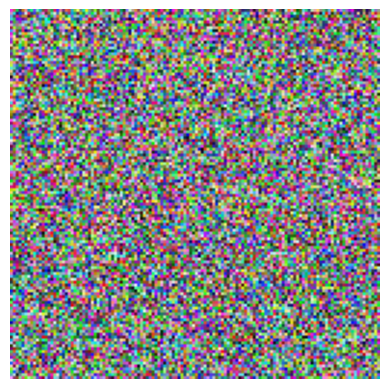

In [52]:
plt.imshow(img)
plt.axis('off')  
plt.show()

In [15]:
def grid_search_m2(L_lst,beta_lst,enc_layers,dec_layers,VAE_Loss,train_dataloader_vae_inmemory,val_dataloader_vae_inmemory,num_epoch,device,save_path):
    for L in L_lst :
        for beta_val, beta_str in beta_lst:
            if(device.type == 'cuda'):
                torch.cuda.empty_cache()
            model=VAE_m2(enc_layers,dec_layers).to(device)
            optzr=torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=0.0001)
            print("Training model VAE m2: with L=",L," beta=",beta_val,"\n")
            training_outputs_m2 = train_vae(model,optzr,VAE_Loss,train_dataloader_vae_inmemory,val_dataloader_vae_inmemory,num_epoch,device,"vae_model_m2_"+str(L)+"_"+beta_str,save_path,L=L,beta=beta_val)
            print("Training done.")
            
            del model
            del optzr
            del training_outputs_m2
            if(device.type == 'cuda'):
                torch.cuda.empty_cache()


In [16]:
L_lst=[1,3,5,10]
beta_lst=[(0.1,"0d1"),(1.0,"1d0"),(10.0,"10d0"),(100.0,"100d0"),(500.0,"500d0")]

In [17]:
grid_search_m2(L_lst,beta_lst,enc_layers,dec_layers,VAE_Loss,train_dataloader_vae_inmemory,val_dataloader_vae_inmemory,100,device,save_path)

Training model VAE m2: with L= 1  beta= 0.1 

________________ Training VAE ________________

__________________________
Epoch: 0
training loss: 62187773.375
val loss: 4750284.25
time taken: 23.03370189666748  sec
---weights saved---
__________________________

__________________________
Epoch: 1
training loss: 45803939.5625
val loss: 4651919.25
time taken: 21.94207191467285  sec
---weights saved---
__________________________

__________________________
Epoch: 2
training loss: 45033858.0
val loss: 4580200.25
time taken: 22.028950691223145  sec
---weights saved---
__________________________

__________________________
Epoch: 3
training loss: 44161395.8125
val loss: 4448587.875
time taken: 22.08428168296814  sec
---weights saved---
__________________________

__________________________
Epoch: 4
training loss: 43067764.9375
val loss: 4391709.5
time taken: 22.043407440185547  sec
---weights saved---
__________________________

__________________________
Epoch: 5
training loss: 42962253.437

In [17]:
for data in train_dataloader_vae:
    data=data.to(device)
    #print(data.shape)
    output=vae_model(data)
    loss=VAE_Loss(data,output)
    loss.backward()
    print(loss)
    break

tensor(12859.8115, device='cuda:0', grad_fn=<AddBackward0>)
